In [ ]:
# if open from google colab, run this command
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/sales-prediction-gru/ipynb

Mounted at /content/drive
/content/drive/MyDrive/Github/sales-prediction-gru/ipynb


In [ ]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Loading data

In [ ]:
df = pd.read_csv('../data/fakta_penjualan_unv_202112091006.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844679 entries, 0 to 1844678
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   nonota      object 
 1   hari        int64  
 2   bulan       int64  
 3   tahun       int64  
 4   namabarang  object 
 5   satuan      object 
 6   qty         float64
 7   hargajual   float64
 8   hargabeli   float64
 9   hargajual2  float64
 10  kodejenis   object 
 11  jenis       object 
 12  barcode     object 
 13  keuntungan  float64
 14  kodecabang  float64
 15  cabang      float64
dtypes: float64(7), int64(3), object(6)
memory usage: 225.2+ MB


## Drop Column

In [ ]:
df = df.drop(['nonota', 'namabarang', 'hargajual', 'hargabeli', 'hargajual2', 'keuntungan', 'kodecabang', 'cabang'], axis=1)

In [ ]:
df

,hari,bulan,tahun,satuan,qty,kodejenis,jenis,barcode
0,2,11,2015,PCS,1.00,10304,Hair Care (4),8999999033132
1,2,11,2015,PCS,1.00,10307,Oral Care (7),8999999041953
2,2,11,2015,PCS,5.00,10301,Bath Care (1),8999999045944
3,2,11,2015,PCS,1.00,10307,Oral Care (7),8999999707835
4,2,11,2015,PCS,1.00,10308,Skin Care (8),8999999037918 - 26/06/2020
...,...,...,...,...,...,...,...,...
1844674,10,6,2021,PCS,1.00,3030503,Sikat Gigi (Tooth brush),8999999520137
1844675,10,6,2021,PCS,1.00,3030101,Shampoo,8999999033170
1844676,10,6,2021,PCS,1.00,3030501,Pasta Gigi,8999999037765
1844677,10,6,2021,PCS,1.00,3040201,Sabun Cair,8999999036348


## Examine Unique Symbol from Barcode Column

In [ ]:
df['barcode'] = df['barcode'].astype(str).str[:13]
# df.head()

## Split to Data Test & Data Train

In [ ]:
test = df[df['tahun']==2019]
test.head()

,hari,bulan,tahun,satuan,qty,kodejenis,jenis,barcode
1096038,1,1,2019,PCS,1.00,3040302,Pembersih Lantai,8999999407919
1096039,1,1,2019,PCS,2.00,3030602,Sabun Mandi Batang Aromatic,8999999500399
1096040,1,1,2019,BTL,1.00,3030609,Body Lotion Whitening,8999999003067
1096041,1,1,2019,PCS,2.00,3030610,Body Lotion Aromatic,8999999045579
1096042,1,1,2019,BTL,1.00,3040303,Pembersih Toilet,8992747180225


In [ ]:
years = [2016, 2017, 2018]
train = df[df.tahun.isin(years)]
train.head()

,hari,bulan,tahun,satuan,qty,kodejenis,jenis,barcode
65817,1,1,2016,PCS,3.00,10301,Bath Care (1),8999999036607
65818,1,1,2016,PCS,1.00,10308,Skin Care (8),8999999003722
65819,1,1,2016,PCS,1.00,10301,Bath Care (1),8999999036898
66058,1,1,2016,BTL,3.00,10503,Home & Leater Care (3),8992747180201
66059,1,1,2016,PCS,2.00,10503,Home & Leater Care (3),8999999049034


## Transform Column to Date Column

In [ ]:
def column_to_date(data):
    # create date column from hari, bulan, tahun column
    cols = ["hari","bulan","tahun"]
    data['date'] = data[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
    
    # drop hari, bulan, tahun column
    data = data.drop(['hari', 'bulan', 'tahun'], axis=1)
    
    # transformn date column to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    return data

In [ ]:
test = column_to_date(test)
test.head()

,satuan,qty,kodejenis,jenis,barcode,date
1096038,PCS,1.00,3040302,Pembersih Lantai,8999999407919,2019-01-01
1096039,PCS,2.00,3030602,Sabun Mandi Batang Aromatic,8999999500399,2019-01-01
1096040,BTL,1.00,3030609,Body Lotion Whitening,8999999003067,2019-01-01
1096041,PCS,2.00,3030610,Body Lotion Aromatic,8999999045579,2019-01-01
1096042,BTL,1.00,3040303,Pembersih Toilet,8992747180225,2019-01-01


In [ ]:
train = column_to_date(train)
train.head()

,satuan,qty,kodejenis,jenis,barcode,date
65817,PCS,3.00,10301,Bath Care (1),8999999036607,2016-01-01
65818,PCS,1.00,10308,Skin Care (8),8999999003722,2016-01-01
65819,PCS,1.00,10301,Bath Care (1),8999999036898,2016-01-01
66058,BTL,3.00,10503,Home & Leater Care (3),8992747180201,2016-01-01
66059,PCS,2.00,10503,Home & Leater Care (3),8999999049034,2016-01-01


In [ ]:
train['qty'] = train['qty'].astype(int)

## Get month number from Date

In [ ]:
train['month_yr'] = train['date'].apply(lambda x: x.strftime('%m-%y')).astype(str)

In [ ]:
train['month_yr'] = train['month_yr'].map({'01-16':0,'02-16':1,'03-16':2,'04-16':3,'05-16':4,'06-16':5,'07-16':6,'08-16':7,'09-16':8,'10-16':9,'11-16':10,'12-16':11,
                                          '01-17':12,'02-17':13,'03-17':14,'04-17':15,'05-17':16,'06-17':17,'07-17':18,'08-17':19,'09-17':20,'10-17':21,'11-17':22,'12-17':23,
                                          '01-18':24,'02-18':25,'03-18':26,'04-18':27,'05-18':28,'06-18':29,'07-18':30,'08-18':31,'09-18':32,'10-18':33,'11-18':34,'12-18':35})

In [ ]:
display(train)
display(train.info())

,satuan,qty,kodejenis,jenis,barcode,date,month_yr
65817,PCS,3,10301,Bath Care (1),8999999036607,2016-01-01,0
65818,PCS,1,10308,Skin Care (8),8999999003722,2016-01-01,0
65819,PCS,1,10301,Bath Care (1),8999999036898,2016-01-01,0
66058,BTL,3,10503,Home & Leater Care (3),8992747180201,2016-01-01,0
66059,PCS,2,10503,Home & Leater Care (3),8999999049034,2016-01-01,0
...,...,...,...,...,...,...,...
1096033,PCS,1,10304,Hair Care (4),8999999033224,2018-12-31,35
1096034,PCS,1,10308,Skin Care (8),8999999528805,2018-12-31,35
1096035,PCS,1,10503,Home & Leater Care (3),8999999390198,2018-12-31,35
1096036,PCS,1,10502,Detergent (2),8999999526870,2018-12-31,35


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029983 entries, 65817 to 1096037
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   satuan     1029983 non-null  object        
 1   qty        1029983 non-null  int64         
 2   kodejenis  1029983 non-null  object        
 3   jenis      1029983 non-null  object        
 4   barcode    1029983 non-null  object        
 5   date       1029983 non-null  datetime64[ns]
 6   month_yr   1029983 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 62.9+ MB


None

In [ ]:
train['month_yr'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

In [ ]:
print(f"Min date from data set: {test['date'].min().date()}")
print(f"Max date from data set: {test['date'].max().date()}")

Min date from data set: 2019-01-01
Max date from data set: 2019-12-31


In [ ]:
print(f"Min date from data set: {train['date'].min().date()}")
print(f"Max date from data set: {train['date'].max().date()}")

Min date from data set: 2016-01-01
Max date from data set: 2018-12-31


## Prepare test dataset

Leaving only the barcode that exist in the test set to have more accurate results.
Drop satuan, kodejenis, jenis and date column

In [ ]:
test = test.drop(['satuan', 'qty', 'kodejenis', 'jenis', 'date'], axis=1)
test.head()

,barcode
1096038,8999999407919
1096039,8999999500399
1096040,8999999003067
1096041,8999999045579
1096042,8992747180225


In [ ]:
# test_shop_ids = test['shop_id'].unique()
# test_item_ids = test['item_id'].unique()
# # Only shops that exist in test set.
# train = train[train['shop_id'].isin(test_shop_ids)]
# # Only items that exist in test set.
# train = train[train['item_id'].isin(test_item_ids)]

test_barcode = test['barcode'].unique()
# Only items that exist in test set.
train = train[train['barcode'].isin(test_barcode)]

## Data preprocessing

- I'm dropping all features but "item_cnt_day" because I'll be using only it as a univariate time-series.
- We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's aggregate the data by month.
- Also I'm leaving only monthly "item_cnt" >= 0 and <= 20, as this seems to be the distributions of the test set.

In [ ]:
display(train.head())
display(train.info())

,satuan,qty,kodejenis,jenis,barcode,date,month_yr
65817,PCS,3,10301,Bath Care (1),8999999036607,2016-01-01,0
65819,PCS,1,10301,Bath Care (1),8999999036898,2016-01-01,0
66058,BTL,3,10503,Home & Leater Care (3),8992747180201,2016-01-01,0
66059,PCS,2,10503,Home & Leater Care (3),8999999049034,2016-01-01,0
66060,PCS,1,10307,Oral Care (7),8999999715588,2016-01-01,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 805447 entries, 65817 to 1096037
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   satuan     805447 non-null  object        
 1   qty        805447 non-null  int64         
 2   kodejenis  805447 non-null  object        
 3   jenis      805447 non-null  object        
 4   barcode    805447 non-null  object        
 5   date       805447 non-null  datetime64[ns]
 6   month_yr   805447 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 49.2+ MB


None

In [ ]:
# train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
# train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
# train_monthly = train_monthly.agg({'item_cnt_day':['sum']})
# train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
# train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')
# Label
# train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

# display(train_monthly.head(10).T)
# display(train_monthly.describe().T)

train_monthly = train[['date', 'month_yr', 'satuan', 'kodejenis', 'barcode', 'qty']]
train_monthly = train_monthly.sort_values('date').groupby(['month_yr', 'satuan', 'kodejenis', 'barcode'], as_index=False)
train_monthly = train_monthly.agg({'qty':['sum']})
train_monthly.columns = ['month_yr', 'satuan', 'kodejenis', 'barcode', 'qty_cnt']
train_monthly = train_monthly.query('qty_cnt >= 0 and qty_cnt <= 20')

# Label
train_monthly['qty_cnt_month'] = train_monthly.sort_values('month_yr').groupby(['barcode', 'satuan', 'kodejenis'])['qty_cnt'].shift(-1)

display(train_monthly.head(10))
display(train_monthly.describe())

,month_yr,satuan,kodejenis,barcode,qty_cnt,qty_cnt_month
7,0,BDD,10304,8999999047900,12,11.00
10,0,BDD,10304,8999999048280,13,2.00
14,0,BDD,10503,8999999059811,2,2.00
15,0,BDD,10506,8999999045616,6,2.00
21,0,BTL,10103,8992694246173,7,8.00
22,0,BTL,10204,8999999029562,12,17.00
24,0,BTL,10301,8999999001148,7,11.00
25,0,BTL,10301,8999999001155,6,6.00
26,0,BTL,10301,8999999001162,19,12.00
31,0,BTL,10301,8999999009595,6,15.00


,month_yr,qty_cnt,qty_cnt_month
count,14529.00,14529.00,13220.00
mean,19.30,7.70,7.58
std,9.63,5.59,5.53
min,0.00,1.00,1.00
25%,12.00,3.00,3.00
50%,20.00,6.00,6.00
75%,27.00,12.00,12.00
max,35.00,20.00,20.00


## Time-Series Processing

- As I only need the "item_cnt" feature as a series, I can get that easily by just using a pivot operation.
- This way I'll also get the missing months from each "shop_id" and "item_id", and then replace them with 0 (otherwise would be "nan").

In [ ]:
monthly_series = train_monthly.pivot_table(index=['barcode', 'satuan', 'kodejenis'], columns='month_yr',values='qty_cnt', fill_value=0).reset_index()
monthly_series.head()

month_yr,barcode,satuan,kodejenis,0,1,2,3,4,5,6,...,26,27,28,29,30,31,32,33,34,35
0,4800888137319,PCS,10206,0,0,0,0,0,0,0,...,16,15,15,9,17,11,13,14,14,13
1,4800888137319,PCS,10206,15,0,0,12,0,17,0,...,0,0,0,0,0,0,0,0,0,0
2,4800888141125,PCS,10206,0,0,0,0,0,0,0,...,0,0,0,0,0,0,13,0,0,0
3,4800888141125,PCS,10206,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4800888157942,PCS,10202,0,0,0,0,0,0,0,...,1,2,2,0,1,5,4,1,1,4


Currently I have one series (33 months) for each unique pair of "shop_id" and "item_id", but probably would be better to have multiple smaller series for each unique pair, so I'm generating multiple series of size 12 (one year) for each unique pair

In [ ]:
first_month = 23
last_month = 35
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['barcode'], row['satuan'], row['kodejenis']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['barcode', 'satuan', 'kodejenis']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,barcode,satuan,kodejenis,0,1,2,3,4,5,6,7,8,9,10,11,label
0,4800888137319,PCS,10206,7,0,11,16,15,15,9,17,11,13,14,14,13
1,4800888137319,PCS,10206,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4800888141125,PCS,10206,0,0,0,0,0,0,0,0,0,13,0,0,0
3,4800888141125,PCS,10206,3,0,0,0,0,0,0,0,0,0,0,0,0
4,4800888157942,PCS,10202,7,19,13,1,2,2,0,1,5,4,1,1,4


## Dropping identifier columns as we don't need them anymore

In [ ]:
data_series = data_series.drop(['barcode', 'satuan', 'kodejenis'], axis=1)

## Train and validation sets

In [ ]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

In [ ]:
print("Train set", train.shape)
print("Validation set", valid.shape)
train.head()

Train set (1178, 12)
Validation set (131, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
184,4,0,0,0,0,0,0,0,0,0,0,0
418,0,0,0,0,0,0,0,0,0,0,0,0
295,17,11,17,10,9,12,11,2,11,11,4,10
14,2,0,0,0,0,0,0,0,0,0,0,0
1046,0,0,4,0,0,3,0,0,0,0,1,0


## Reshape data.

- Time-series shape (data points, time-steps, features).

In [ ]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (1178, 12, 1)
Validation set reshaped (131, 12, 1)


## Regular GRU model.

In [ ]:
serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

epochs = 100
batch = 32
lr = 0.0001

lstm_model = Sequential()
lstm_model.add(L.GRU(10, input_shape=(serie_size, n_features), return_sequences=True))
lstm_model.add(L.GRU(6, activation='relu', return_sequences=True))
lstm_model.add(L.GRU(1, activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(1))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 10)            390       
                                                                 
 gru_1 (GRU)                 (None, 12, 6)             324       
                                                                 
 gru_2 (GRU)                 (None, 1)                 27        
                                                                 
 dense (Dense)               (None, 10)                20        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 882
Trainable params: 882
Non-trainable pa

In [ ]:
lstm_history = lstm_model.fit(X_train, Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

Epoch 1/100
37/37 - 6s - loss: 42.1162 - val_loss: 44.4887 - 6s/epoch - 155ms/step
Epoch 2/100
37/37 - 1s - loss: 41.9668 - val_loss: 44.3134 - 553ms/epoch - 15ms/step
Epoch 3/100
37/37 - 1s - loss: 41.7845 - val_loss: 44.1072 - 552ms/epoch - 15ms/step
Epoch 4/100
37/37 - 1s - loss: 41.5660 - val_loss: 43.8612 - 568ms/epoch - 15ms/step
Epoch 5/100
37/37 - 1s - loss: 41.3092 - val_loss: 43.5619 - 551ms/epoch - 15ms/step
Epoch 6/100
37/37 - 1s - loss: 41.0019 - val_loss: 43.2163 - 577ms/epoch - 16ms/step
Epoch 7/100
37/37 - 1s - loss: 40.6392 - val_loss: 42.8010 - 567ms/epoch - 15ms/step
Epoch 8/100
37/37 - 1s - loss: 40.2057 - val_loss: 42.3052 - 552ms/epoch - 15ms/step
Epoch 9/100
37/37 - 1s - loss: 39.6930 - val_loss: 41.7044 - 574ms/epoch - 16ms/step
Epoch 10/100
37/37 - 1s - loss: 39.0670 - val_loss: 41.0064 - 566ms/epoch - 15ms/step
Epoch 11/100
37/37 - 1s - loss: 38.3278 - val_loss: 40.1363 - 566ms/epoch - 15ms/step
Epoch 12/100
37/37 - 1s - loss: 37.4329 - val_loss: 39.0923 - 540

###### Model training

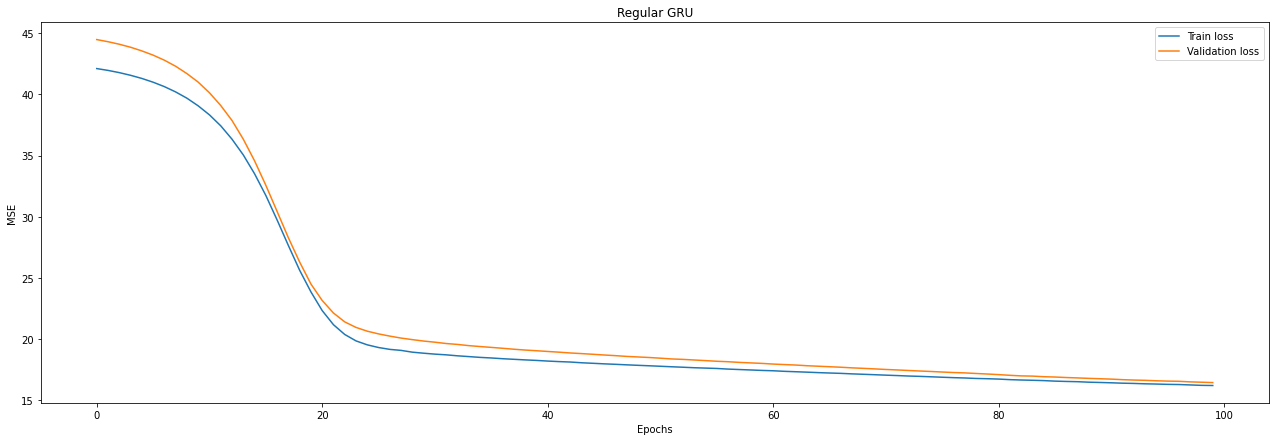

In [ ]:
fig, ax1 = plt.subplots(1, sharey=True,figsize=(22,7))

ax1.plot(lstm_history.history['loss'], label='Train loss')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Regular GRU')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

plt.show()

##### Regular GRU on train and validation

In [ ]:
lstm_train_pred = lstm_model.predict(X_train)
lstm_val_pred = lstm_model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))

Train rmse: 4.019836058436103
Validation rmse: 4.053270394145841


##### Build test set
Since we have two models I'll build test sets to apply on both of them.

In [ ]:
latest_records = monthly_series.drop_duplicates(subset=['barcode', 'satuan', 'kodejenis'])
X_test = pd.merge(test, latest_records, on=['barcode'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['barcode', 'satuan', 'kodejenis'], axis=1, inplace=True)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,16.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,17.00,0.00,0.00,0.00,0.00,19.00,10.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


##### Regular LSTM model test predictions
- For the regular LSTM model we just need the last 12 months, because that's our series input size.

In [ ]:
X_test = X_test[[(i + (35 - serie_size)) for i in range(serie_size)]]
X_test.head()

,23,24,25,26,27,28,29,30,31,32,33,34
0,9.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,19.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,17.00,0.00,0.00,0.00,0.00,19.00,10.00
4,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


##### Reshape data.
- Time-series shape (data points, time-steps, features).

In [ ]:
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test_reshaped.shape)

(453498, 12, 1)


##### Making predictions.

In [ ]:
lstm_test_pred = lstm_model.predict(X_test_reshaped)

##### Predictions from the regular GRU model.

In [ ]:
lstm_test_pred

array([[0.43093383],
       [0.54194087],
       [0.2509539 ],
       ...,
       [0.18485895],
       [0.313295  ],
       [0.18485893]], dtype=float32)

In [ ]:
# lstm_prediction = pd.DataFrame(test['barcode'], columns=['barcode'])
# lstm_prediction['item_cnt_month'] = lstm_test_pred.clip(0., 20.)
# lstm_prediction.head(10)

# lstm_prediction.to_csv('gru_submission.csv', index=False)